# JupyerLab notebook example for Pulse Structure investigations

/!\ /!\ /!\  
Oxygen diffusion from cell environment not (yet) included in the model.  
Therefore, the oxygen level is reinitialized before each new pulse.  

## Module imports

In [1]:
# External modules (to "pip install")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.integrate import simpson, cumulative_trapezoid
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Modules from Standard lib
from pathlib import Path
import typing as tp

# RadioBio module
import radiopyo as rp
from radiopyo.simulation.utils import ResCollection

ModuleNotFoundError: No module named 'radiopyo.simulation'

In [2]:
from Plot_template import RPlot, FigManager, CMap
RPlot.init_rcparams()
fig_man = FigManager()

### Definition of useful funcs

In [3]:
# Some common plot options for uniformity
RIGHT_LIMIT = 1e3

def make_basic_plot(fig:plt.Figure,
                    ax:plt.Axes,
                    species:str,
                    rescoll:ResCollection,
                    title:str="",
                    xscale:str="log",
                    yscale:str="log",
                    ylim:tp.Tuple[float, float]=(1e-6, 10),
                    xlim:tp.Tuple[float, float]=(1e-6, RIGHT_LIMIT),
                    legend:bool=True,
                    legend_title:str="",
                   ):
    for label, df in rescoll.iter_pandas():
        ax.plot(df.index, df[species], label=label, marker="")

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    ax.set_title(title)
    if legend:
        ax.legend(fancybox=True, framealpha=1, title=legend_title if len(legend_title)>0 else None)

def extract_AUC(species:str,
                rescoll:ResCollection,):
    out = pd.Series(dtype=np.float64)
    for adr, df in rescoll.iter_pandas():
        out.loc[adr] = simpson(y=df[species].values.clip(min=0), x=df.index)
    return out.fillna(0.0, inplace=False)

def plot_AUC(fig:plt.Figure,
             ax:plt.Axes,
             species:str,
             rescoll:ResCollection,
             title:str="",
             xscale:str="log",
             yscale:str="linear",
             ylim:tp.Optional[tp.Tuple[float, float]]=None,
             xlim:tp.Optional[tp.Tuple[float, float]]=None,
             legend:bool=False,
             norm:bool=True,
            ):
    adf = extract_AUC(species, rescoll)
    if norm:
        if ylim is None:
            ylim = [0.0, 1.1]
        adf /= adf.max()
    ax.plot(adf.index, adf, marker="x")
    
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlabel(rescoll.label_name())
    ax.set_ylabel(f"AUC [{species}]")
    ax.set_title(title)
    if legend:
        ax.legend(fancybox=True, framealpha=1)

def reaction_dict_to_latex(rdict=tp.Dict) -> str:
    out = [r"$\mathregular{"]
    for key, (elt, stoi) in rdict["reactants"].items():
        latex = elt.to_latex().strip("$")
        out.append(f"{stoi if stoi>1 else ''}{latex}")
        out.append(r"\ +\ ")
    out.pop()
    out.append(r"\ \rightarrow\ ")
    for key, (elt, stoi) in rdict["products"].items():
        latex = elt.to_latex().strip("$")
        out.append(f"{stoi if stoi>1 else ''}{latex}")
        out.append(r"\ +\ ")
    out.pop()
    out.append("}$")
    return "".join(out)

## Simulation Run

**1) Load configuration from the toml file +**  
 -> create a ref to O2 species for later use  
 -> define the desired number of pulses  
 -> define the period

In [3]:
file = Path(rf"configuration_ELBE.toml")
uc = rp.UnitCell.from_toml(file)

2023-07-31 10:16:44,775::radiopyo::INFO::Loading config from file: configuration_ELBE.toml
2023-07-31 10:16:44,783::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\config_Labarbe.toml
2023-07-31 10:16:44,785::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-07-31 10:16:45,023::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\reactions_biology.toml
2023-07-31 10:16:45,063::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-07-31 10:16:45,304::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-07-31 10:16:45,498::radiopyo::INFO::File is loaded
2023-07-31 10:16:45,499::radiopyo::INFO::Beam configuration detected in config file
2023-07-31 10:16:45,500::radiopyo::INFO::BEAM:: Assigning 'default' name to beam definition constant -> {'dose_rate': 0.13, 'max_dose': 32, 's

## Simulation Run LOOP

In [8]:
rp.set_logging_level("ERROR")

In [56]:
uc.beam_list.current

ConstantBeam(dose_rate=110000.0, timer=Timer(period=inf, on_time=inf, start_time=0.0), max_dose=32, label='default', time_at_max_dose=0.0002909090909090909, dose_per_pulse=inf, peak_dose_rate=110000.0)

In [51]:
sims = ResCollection("Dose Rate [Gy/s]")
for adr in [0.13, 1, 10, 150, 201.9, 319, 1e3, 1e4, 1.1e5]:
    uc.beam_list.current.update_beam_param(dose_rate=adr)
    sim = uc.prepare_chunked_run([1e-9, 600], atol=1e-1, rtol=1e-2, use_jac=False)
    sims.push(adr, sim.run())



2023-07-31 11:03:54,487::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:03:54,489::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:03:54,633::radiopyo::INFO::Simulation done!
2023-07-31 11:03:54,634::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:03:54,636::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:03:54,749::radiopyo::INFO::Simulation done!
2023-07-31 11:03:54,749::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:03:54,752::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:03:54,852::radiopyo::INFO::Simulation done!
2023-07-31 11:03:54,853::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:03:54,857::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:03:58,905::radiopyo::INFO::Simulation done!
2023-07-31 11:03:58,906::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:03:58,909::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:04:02,832::radiopyo::INFO::Simulation done!
2023-07-31 11:04:02,833::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:04:02,836::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:04:03,084::radiopyo::INFO::Simulation done!
2023-07-31 11:04:03,085::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:04:03,088::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:04:03,328::radiopyo::INFO::Simulation done!
2023-07-31 11:04:03,329::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:04:03,332::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:04:03,580::radiopyo::INFO::Simulation done!
2023-07-31 11:04:03,581::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-31 11:04:03,584::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-31 11:04:07,450::radiopyo::INFO::Simulation done!


In [56]:
bins = np.arange(start=0, stop=df.index[-1], step=1e-3)
df.groupby(pd.cut(df["KR_7"], bins=bins)).

## Results usage

### Plot

#### Water-only Radiolytic produced species

In [53]:
fig_man.set_brewer_map("RdYlGn", "diverging", 9, reverse=True)

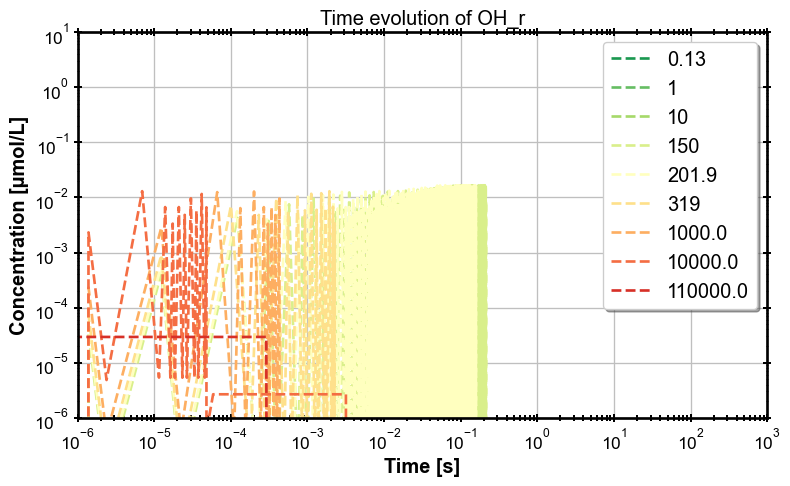

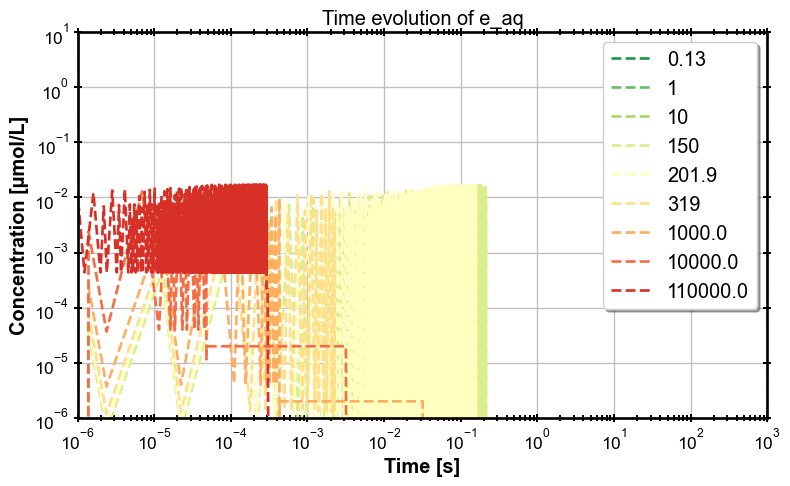

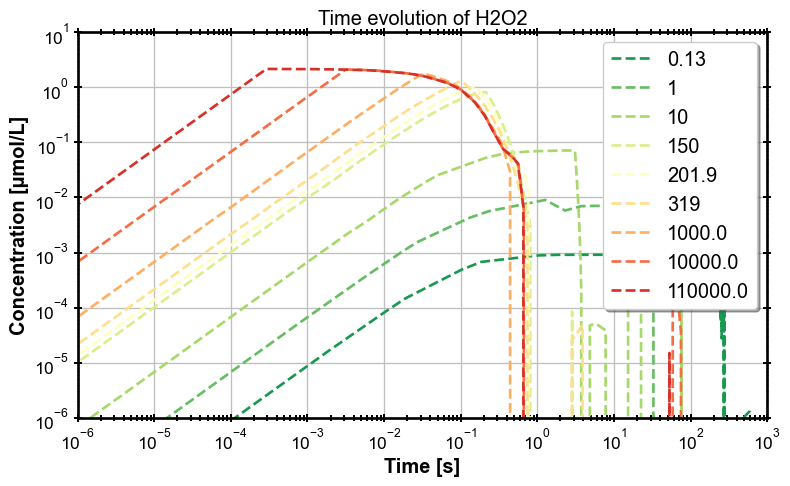

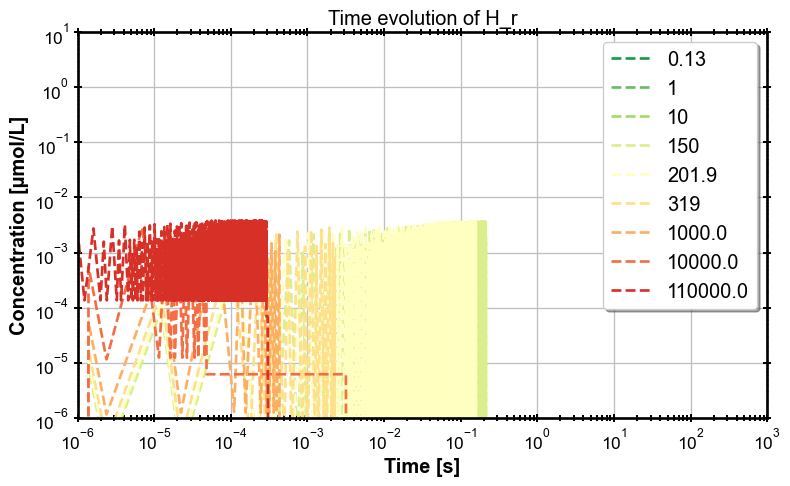

In [54]:
G_species = ["OH_r", "e_aq", "H2O2", "H_r"]
for species in G_species:
    title = f"Time evolution of {species}"
    with fig_man.open(title) as (fig, ax):
        make_basic_plot(fig, ax, species, sims, title)

#### Biology related species

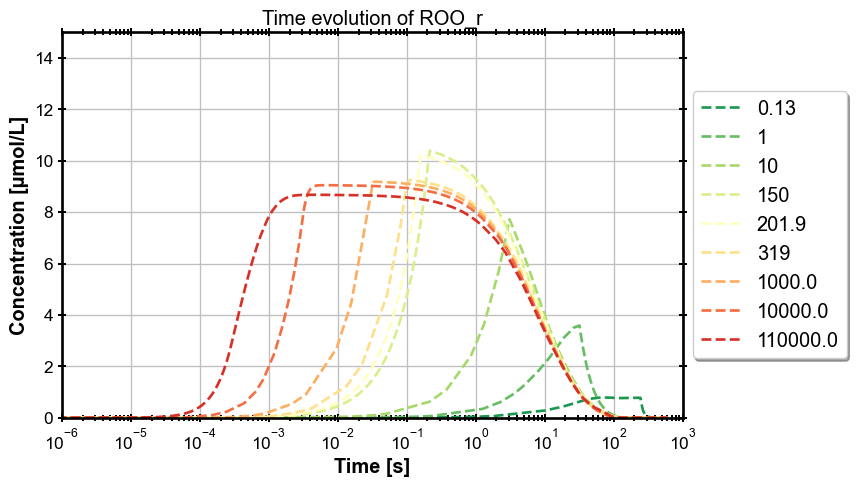

In [58]:
species = "ROO_r"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sims, title, legend=False, yscale="linear", ylim=[0,15])
    RPlot.set_legend_right(ax)

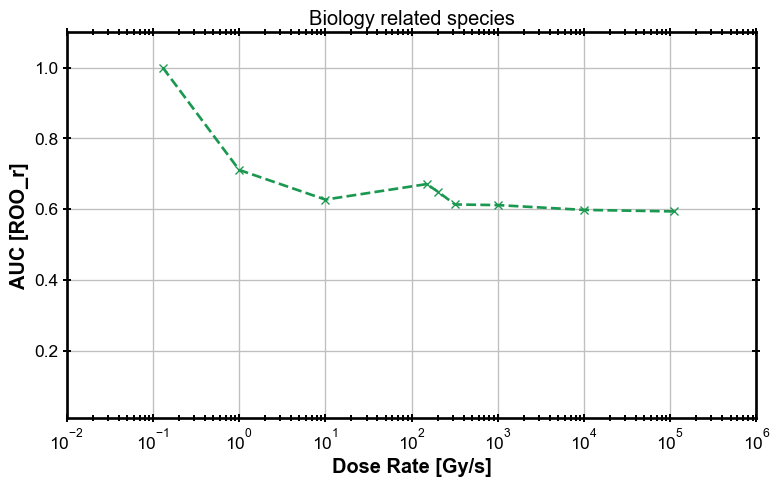

In [59]:
species = "ROO_r"
adf = pd.Series(dtype=np.float64)
for adr, df in sims.iter_pandas():
    mask = np.where((df.index>=1e-6))
    adf.loc[adr] = simpson(y=df[species].values[mask].clip(min=0), x=df.index[mask])
    
with fig_man.open(f"Comparison of {species} ROO_r") as (fig, ax):
    
    ax.plot(adf.index, adf/adf.max(), marker="x")

    #ax.set_ylim(bottom=1e-6, top=2)
    ax.set_ylim([0.01, 1.1])
    #ax.set_xlim([0, 100])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Dose Rate [Gy/s]")
    ax.set_ylabel("AUC [ROO_r]")

    ax.set_title("Biology related species")

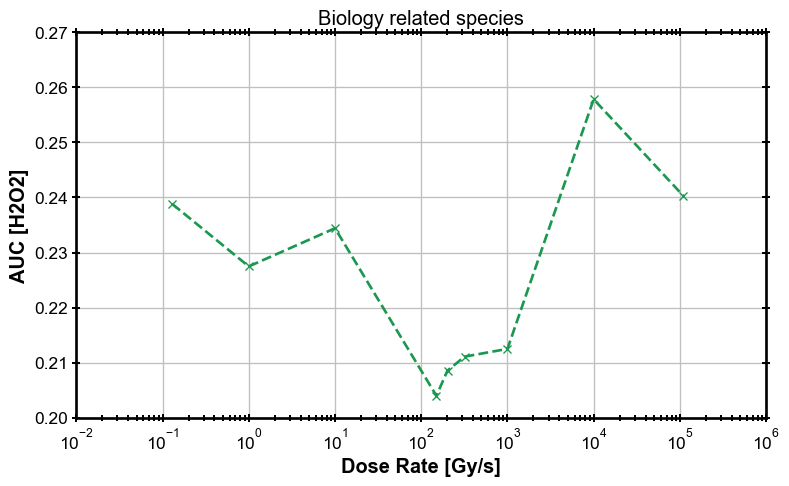

In [61]:
species = "H2O2"
adf = pd.Series(dtype=np.float64)
for adr, df in sims.iter_pandas():
    mask = np.where((df.index>=1e-6))
    adf.loc[adr] = simpson(y=df[species].values[mask].clip(min=0), x=df.index[mask])
    
with fig_man.open(f"Comparison of {species} ROO_r") as (fig, ax):
    
    ax.plot(adf.index, adf, marker="x")

    #ax.set_ylim(bottom=1e-6, top=2)
    #ax.set_ylim([0.5, 1.1])
    #ax.set_xlim([0, 100])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Dose Rate [Gy/s]")
    ax.set_ylabel("AUC [H2O2]")

    ax.set_title("Biology related species")

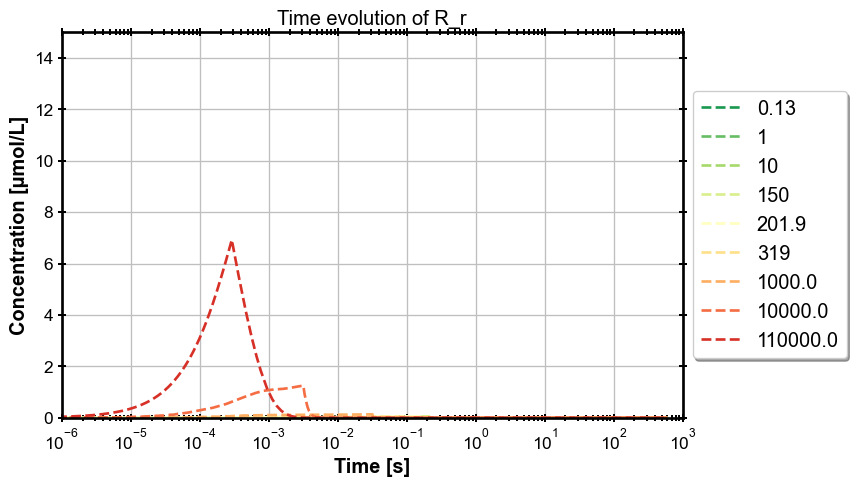

In [63]:
species = "R_r"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sims, title, legend=False, yscale="linear", ylim=[0,15])
    RPlot.set_legend_right(ax)

#### O2

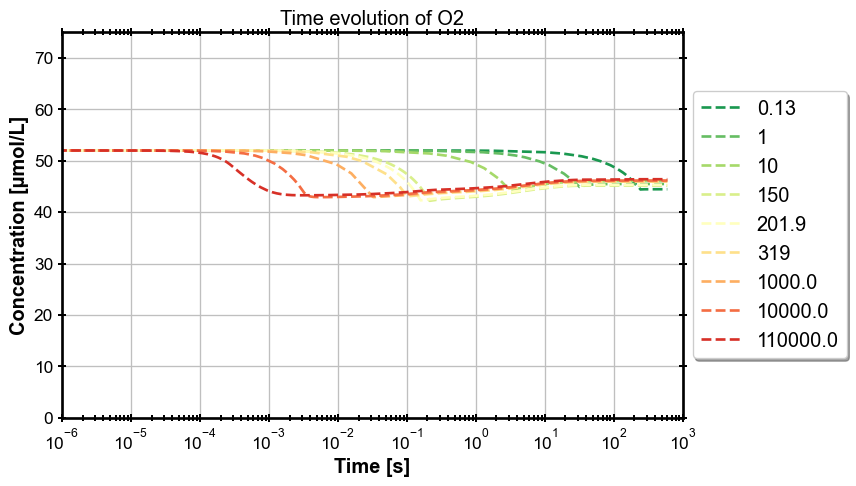

In [65]:
species = "O2"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sims, title, legend=False, yscale="linear", ylim=[0,75])
    RPlot.set_legend_right(ax)

## Oxygen concentration evolution

## Load literature data

In [4]:
from plot_digitizer import CSVReader
file = "FIG_1A.csv"
path = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\DATA_EPT\LITTERATURE\Radiation-Chemical Oxygen Depletion Depends on Chemical Environment and Dose Rate Implications for the FLASH Effect")

csv = CSVReader().read_data(path/file)

## Simulate

In [22]:
from matplotlib.pyplot import cm
import matplotlib.patches as patches

In [27]:
file = Path(rf"configuration_ELBE.toml")
uc = rp.UnitCell.from_toml(file)
uc.set_beam("O2_depletion")
uc.use_acid_base(False)
sim = uc.prepare_chunked_run([1e-9, 300],
                             atol=7.5e-1,
                             rtol=1e-4,
                             use_jac=False,
                             max_step_size_on=uc.beam.time_at_max_dose/1e3,
                             max_step_size_off=0.1,
                             max_step_size_final=0.1,
                            )
res = sim.run()
df = res.to_pandas()

2023-08-04 14:34:30,322::radiopyo::INFO::Loading config from file: configuration_ELBE.toml
2023-08-04 14:34:30,328::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-08-04 14:34:30,555::radiopyo::INFO::File is loaded
2023-08-04 14:34:30,556::radiopyo::INFO::Beam configuration detected in config file
2023-08-04 14:34:30,557::radiopyo::INFO::BEAM:: Assigning 'default' name to beam definition constant -> {'dose_rate': 0.13, 'max_dose': 32, 'start_time': 0.0, 'LET': 0.27}
2023-08-04 14:34:30,559::radiopyo::INFO::BEAM:: Found beam 'O2_depletion_conv' as constant -> {'dose_rate': 1, 'max_dose': 32, 'start_time': 30, 'label': 'O2_depletion_conv', 'LET': 0.27}
2023-08-04 14:34:30,561::radiopyo::INFO::BEAM:: Found beam 'O2_depletion' as pulsed -> {'dose_rate': 0.26363636363636367, 'period': 121, 'on_time': 0.1, 'max_dose': 31.900000000000002, 'start_time': 30, 'label': 'O2_depletion', 'LET': 0.27}
2023-08-04 14:34:30,562::rad

  0%|          | 0/3 [00:00<?, ?it/s]

2023-08-04 14:34:31,529::radiopyo::INFO::Simulation done!


In [32]:
file = Path(rf"configuration_ELBE.toml")
uc = rp.UnitCell.from_toml(file)
uc.set_beam("O2_depletion_conv")
uc.use_acid_base(False)
sim = uc.prepare_chunked_run([1e-9, 300],
                             atol=10,
                             rtol=1e-2,
                             use_jac=False,
                             max_step_size_on=uc.beam.time_at_max_dose/1e3,
                             max_step_size_off=0.1,
                             max_step_size_final=0.1,
                            )
conv = sim.run()
df_conv = res.to_pandas()

2023-08-04 14:42:18,061::radiopyo::INFO::Loading config from file: configuration_ELBE.toml
2023-08-04 14:42:18,064::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-08-04 14:42:18,263::radiopyo::INFO::File is loaded
2023-08-04 14:42:18,263::radiopyo::INFO::Beam configuration detected in config file
2023-08-04 14:42:18,264::radiopyo::INFO::BEAM:: Assigning 'default' name to beam definition constant -> {'dose_rate': 0.13, 'max_dose': 32, 'start_time': 0.0, 'LET': 0.27}
2023-08-04 14:42:18,266::radiopyo::INFO::BEAM:: Found beam 'O2_depletion_conv' as constant -> {'dose_rate': 1, 'max_dose': 32, 'start_time': 30, 'label': 'O2_depletion_conv', 'LET': 0.27}
2023-08-04 14:42:18,268::radiopyo::INFO::BEAM:: Found beam 'O2_depletion' as pulsed -> {'dose_rate': 0.26363636363636367, 'period': 121, 'on_time': 0.1, 'max_dose': 31.900000000000002, 'start_time': 30, 'label': 'O2_depletion', 'LET': 0.27}
2023-08-04 14:42:18,269::rad

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

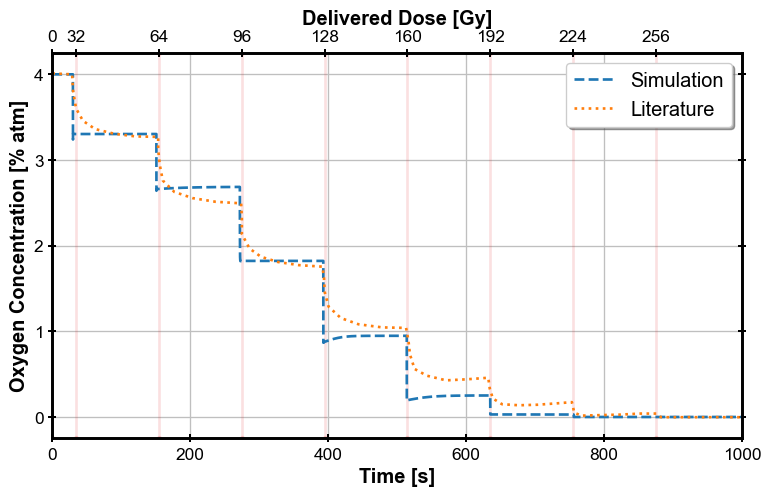

In [18]:
species = "O2"
fig_man.set_mpl_map("tab10", 10)
with fig_man.open(f"Comparison of {species}") as (fig, ax):
    
    xmin, xmax = xlim = 0, 1000
    ymin, ymax = ylim = -0.25, 4.25
    X = np.array([0, 35]+[(155+elt*120) for elt in range(8)])
    
    #X = np.linspace(150, 990, 8*10)
    #ax2 = fig.add_subplot(111, xlim=xlim, ylim=ylim,
    #                 autoscale_on=False)
    #ax.imshow(X, interpolation='bicubic', cmap=cm.terrain,
    #      extent=(xmin, xmax, ymin, ymax), alpha=0.75)
    #ax.set_aspect('auto')
    for elt in X[:-1]:
        ax.axvline(x=elt, color="#e31a1c22", ls="-")
    ax.plot(df.index, df[species]*1e-6*769.23*100, marker="", label="Simulation")
    
    # Plot literature data
    ax.plot(csv["O2_cc"]["X"], csv["O2_cc"]["Y"], label="Literature", marker="", ls=":")
    
    ax.set_ylim(bottom=-0.25, top=4.25)
    ax.set_xlim([0, 1000])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Oxygen Concentration [% atm]")
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.legend(fancybox=True, framealpha=1)
    
    ax2 = ax.twiny()
    ax2.grid(False)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(X[:-1])
    ax2.set_xticklabels([32*elt for elt in range(len(X)-1)])
    ax2.set_xlabel("Delivered Dose [Gy]")    

    fig.savefig(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802\O2_cc_evolution_modif.png")

In [ ]:
species = "O2"
fig_man.set_mpl_map("tab10", 10)
with fig_man.open(f"Comparison of {species}") as (fig, ax):
    
    xmin, xmax = xlim = 0, 1000
    ymin, ymax = ylim = -0.25, 4.25
    X = np.array([0, 35]+[(155+elt*120) for elt in range(8)])
    
    #X = np.linspace(150, 990, 8*10)
    #ax2 = fig.add_subplot(111, xlim=xlim, ylim=ylim,
    #                 autoscale_on=False)
    #ax.imshow(X, interpolation='bicubic', cmap=cm.terrain,
    #      extent=(xmin, xmax, ymin, ymax), alpha=0.75)
    #ax.set_aspect('auto')
    for elt in X[:-1]:
        ax.axvline(x=elt, color="#e31a1c22", ls="-")
    ax.plot(df.index, df[species]*1e-6*769.23*100, marker="", label="Simulation")
    
    # Plot literature data
    ax.plot(csv["O2_cc"]["X"], csv["O2_cc"]["Y"], label="Literature", marker="", ls=":")
    
    ax.set_ylim(bottom=-0.25, top=4.25)
    ax.set_xlim([0, 1000])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Oxygen Concentration [% atm]")
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.legend(fancybox=True, framealpha=1)
    
    ax2 = ax.twiny()
    ax2.grid(False)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(X[:-1])
    ax2.set_xticklabels([32*elt for elt in range(len(X)-1)])
    ax2.set_xlabel("Delivered Dose [Gy]")    

    fig.savefig(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802\O2_cc_evolution_modif.png")

# Irradiation at Ultra-High (FLASH) Dose Rates Reduces Acute Normal Tissue Toxicity in the Mouse Gastrointestinal System - 2021
doi: 10.1016/j.ijrobp.2021.08.004

## Load literature data

In [4]:
from plot_digitizer import CSVReader
file = "FIG_02_A.csv"
path = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\DATA_EPT\LITTERATURE\Irradiation at Ultra-High (FLASH) Dose Rates Reduces Acute Normal Tissue Toxicity in the Mouse Gastrointestinal System")

csv = CSVReader().read_data(path/file)

In [282]:
x_values = np.linspace(0.1, 17.8, 150)
df_litt = pd.DataFrame(index=x_values)
df_litt["conv"] = interp1d(x=csv[("CONV IR", "X")].dropna(),
                           y=savgol_filter(csv[("CONV IR", "Y")].dropna(), 5, 2),
                           kind="quadratic")(x_values)

df_litt["flash"] = interp1d(x=csv[("FLASH IR", "X")],
                            y=savgol_filter(csv[("FLASH IR", "Y")], 5, 2),
                                            kind="quadratic")(x_values)

In [284]:
x_values = np.linspace(0.1, 17.8, 150)
df_litt = pd.DataFrame(index=x_values)
df_litt["conv"] = interp1d(x=csv[("CONV IR", "X")].dropna(),
                           y=csv[("CONV IR", "Y")].dropna(),
                           kind="quadratic")(x_values)

df_litt["flash"] = interp1d(x=csv[("FLASH IR", "X")],
                            y=csv[("FLASH IR", "Y")],
                            kind="quadratic")(x_values)

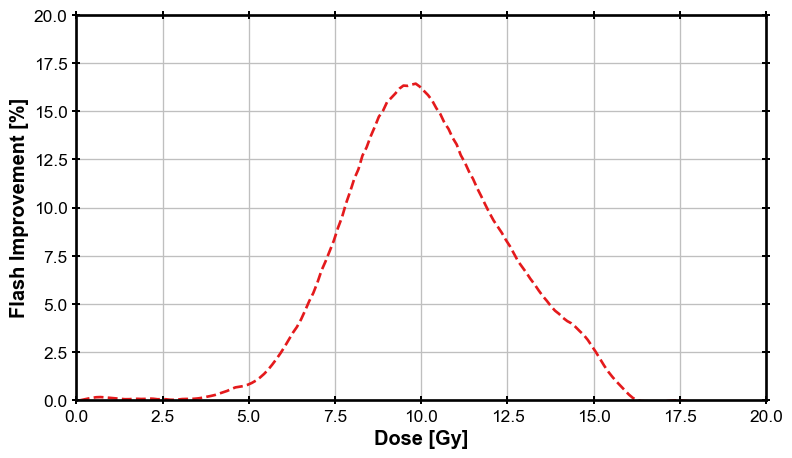

In [294]:
with fig_man.open("Literature data mice") as (fig, ax):
    ax.plot(df_litt.index, savgol_filter((df_litt["flash"]-df_litt["conv"]), 5, 1), marker="")
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.set_xlabel("Dose [Gy]")
    ax.set_ylabel("Flash Improvement [%]")
    fig.savefig(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802\LITT_Flash_improv.png")

## Simulate

In [5]:
file = Path(rf"configuration_Oxford.toml")
rp.set_logging_level("INFO")
uc = rp.UnitCell.from_toml(file)

2023-08-04 15:21:20,819::radiopyo::INFO::Loading config from file: configuration_Oxford.toml
2023-08-04 15:21:20,830::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\config_Labarbe.toml
2023-08-04 15:21:20,833::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-08-04 15:21:21,045::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\reactions_biology.toml
2023-08-04 15:21:21,091::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-08-04 15:21:21,348::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-08-04 15:21:21,570::radiopyo::INFO::File is loaded
2023-08-04 15:21:21,571::radiopyo::INFO::Beam configuration detected in config file
2023-08-04 15:21:21,572::radiopyo::INFO::BEAM:: Found beam 'conv' as pulsed -> {'dose_rate': 0.25, 'period': 0.04, 'on_time': 3.333333333333

In [5]:
uc.env.reactions_involving_reactant("H2O2")

[KReaction('Fe_plus_plus + H2O2 -> Fe_plus_plus_plus + OH_minus + OH_r', k_value=1000.0),
 KReaction('e_aq + H2O2 -> OH_minus + OH_r', k_value=11000000000.0),
 KReaction('H_r + H2O2 -> OH_r + H2O', k_value=90000000.0),
 MichaelisMenten('2H2O2 -- catalase >> O2 + 2H2O', k_value=132400000.0, k_micha=1.1]

## FLASH simulations

In [6]:
flash = rp.simulation.utils.ResCollection("Dose [Gy]")
rp.set_logging_level("ERROR")
for dose in np.arange(0,15,5):
    if dose == 0.0:
        dose = 1e-6
    print(f"Simulations at : {dose} Gy")    
    uc.set_beam("flash")
    uc.beam.update_beam_param(max_dose=dose, dose_rate=dose/3.6e-6)
    print(uc.beam.time_at_max_dose, uc.beam)
    sim = uc.prepare_chunked_run([1e-9, 500],
                                 use_jac=False,
                                 max_step_size_on=uc.beam.time_at_max_dose/1e3,
                                 max_step_size_off=0.1,
                                 max_step_size_final=0.1,
                                )
    flash.push(round(dose,1), sim.run())
    

Simulations at : 1e-06 Gy
3.6e-06 SinglePulseBeam(dose_rate=0.28, max_dose=1e-06, start_time=0.0)


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 5 Gy
3.6e-06 SinglePulseBeam(dose_rate=1.4e+06, max_dose=5, start_time=0.0)


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 10 Gy
3.6e-06 SinglePulseBeam(dose_rate=2.8e+06, max_dose=10, start_time=0.0)


  0%|          | 0/2 [00:00<?, ?it/s]

0.036962039760453404
0.036935785221808376


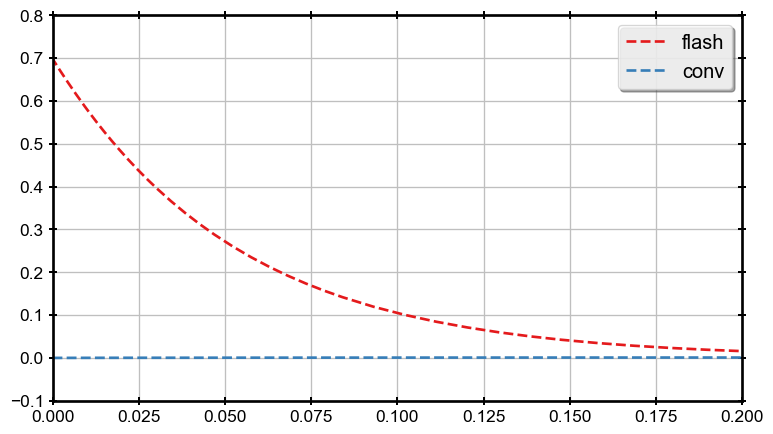

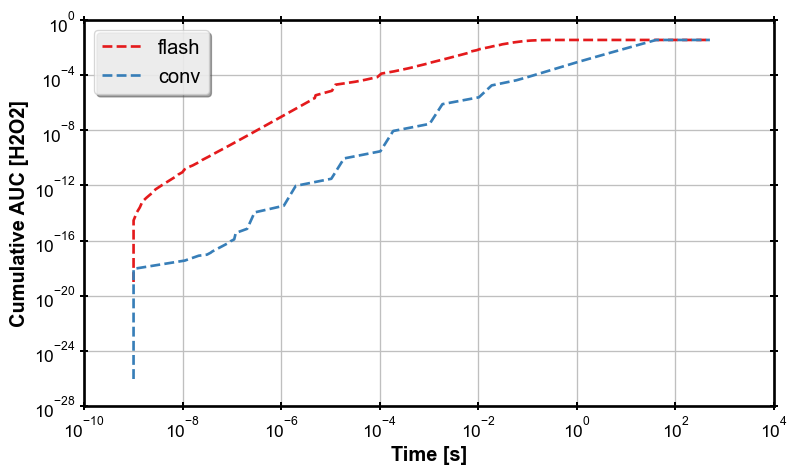

In [227]:
dose = 10
df = flash._results[dose].to_pandas()
print(simpson(y=df["H2O2"].values, x=df.index))

df = conv._results[dose].to_pandas()
print(simpson(y=df["H2O2"].values, x=df.index))

with fig_man.open("H2O2 cmp") as (fig, ax):
    df = flash._results[dose].to_pandas()
    ax.plot(df.index, df["H2O2"], label="flash", marker="")
    df = conv._results[dose].to_pandas()
    ax.plot(df.index, df["H2O2"], label="conv", marker="")
    
    ax.legend()
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    ax.set_xlim([0,0.2])
    
with fig_man.open("H2O2 cmp cumulative") as (fig, ax):
    df = flash._results[dose].to_pandas()
    ax.plot(df.index[:-1], cumulative_trapezoid(x=df.index.values,y=df["H2O2"]), label="flash", marker="")
    df = conv._results[dose].to_pandas()
    ax.plot(df.index[:-1], cumulative_trapezoid(x=df.index.values,y=df["H2O2"]), label="conv", marker="")
    
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Cumulative AUC [H2O2]")
    fig.savefig(Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802")/"cumulative_AUC_cmp_H2O2.png")

25041.00681816612
24946.085953366175


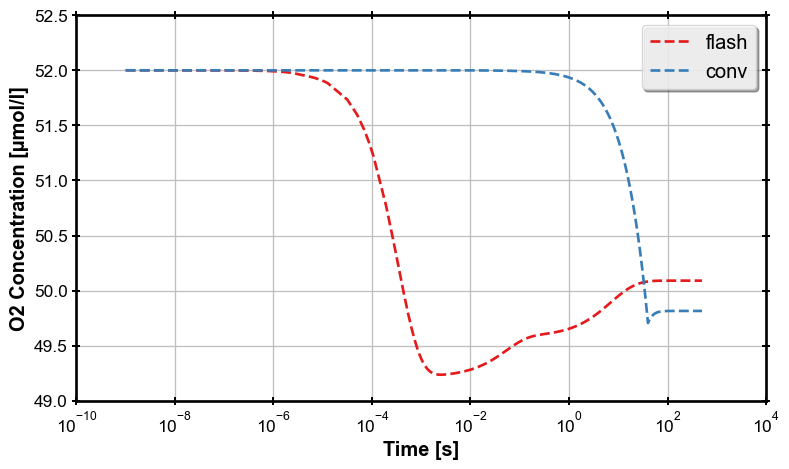

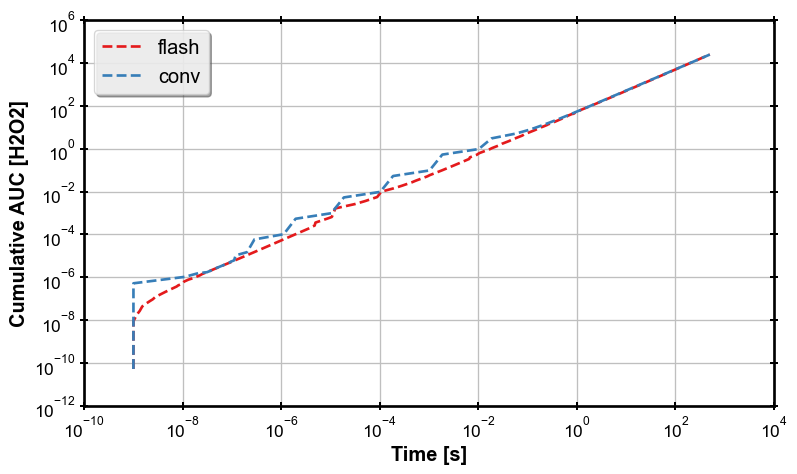

In [232]:
dose = 10
df = flash._results[dose].to_pandas()
print(simpson(y=df["O2"].values, x=df.index))

df = conv._results[dose].to_pandas()
print(simpson(y=df["O2"].values, x=df.index))

with fig_man.open("O2 cmp") as (fig, ax):
    df = flash._results[dose].to_pandas()
    ax.plot(df.index, df["O2"], label="flash", marker="")
    df = conv._results[dose].to_pandas()
    ax.plot(df.index, df["O2"], label="conv", marker="")
    
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("linear")
    #ax.set_xlim([0,0.2])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("O2 Concentration [µmol/l]")
    fig.savefig(Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802")/"O2_time_evo_cmp_10Gy.png")
    
with fig_man.open("O2 cmp cumulative") as (fig, ax):
    df = flash._results[dose].to_pandas()
    ax.plot(df.index[:-1], cumulative_trapezoid(x=df.index.values,y=df["O2"]), label="flash", marker="")
    df = conv._results[dose].to_pandas()
    ax.plot(df.index[:-1], cumulative_trapezoid(x=df.index.values,y=df["O2"]), label="conv", marker="")
    
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Cumulative AUC [H2O2]")
    fig.savefig(Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802")/"cumulative_AUC_cmp_O2.png")

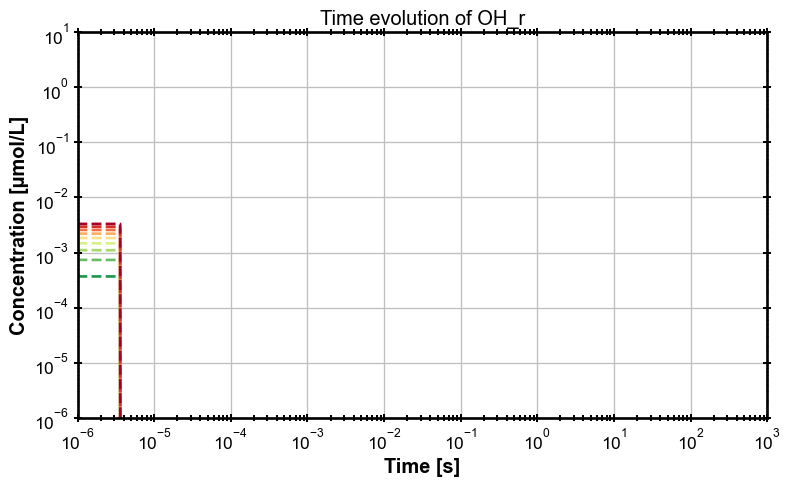

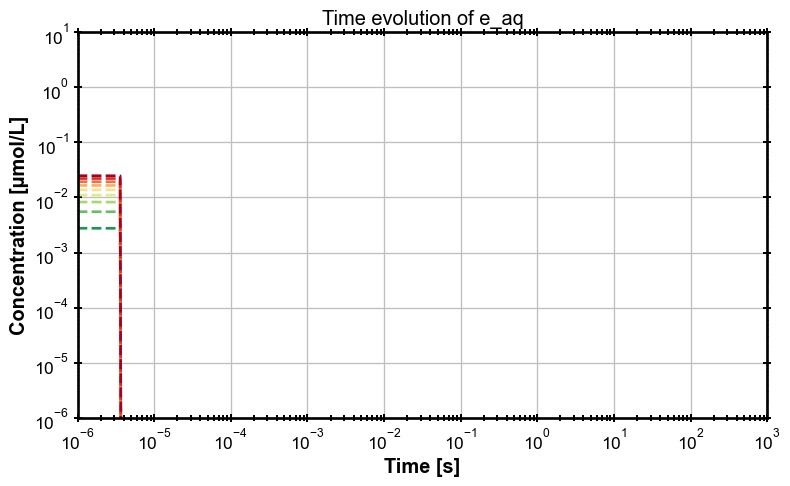

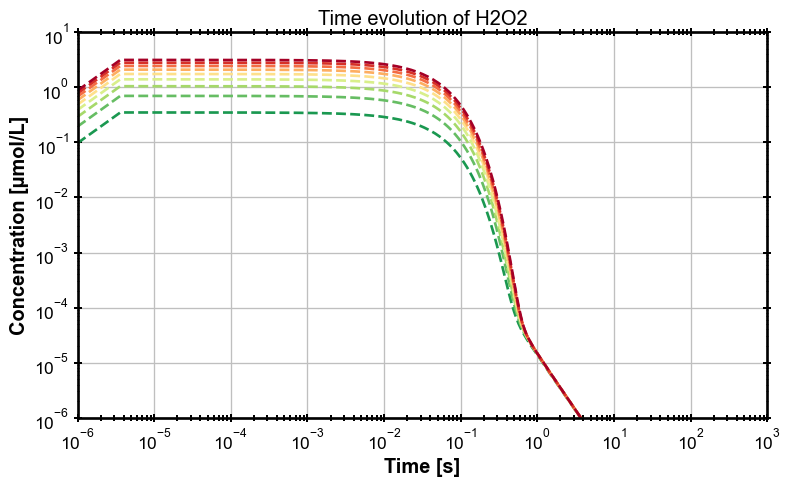

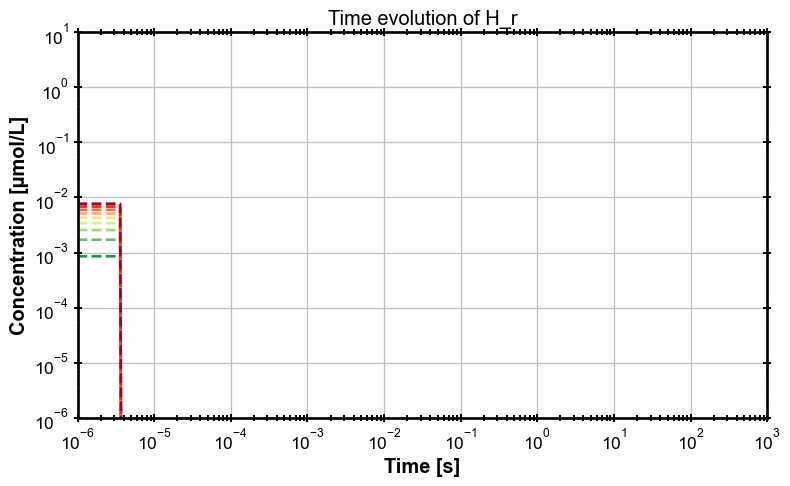

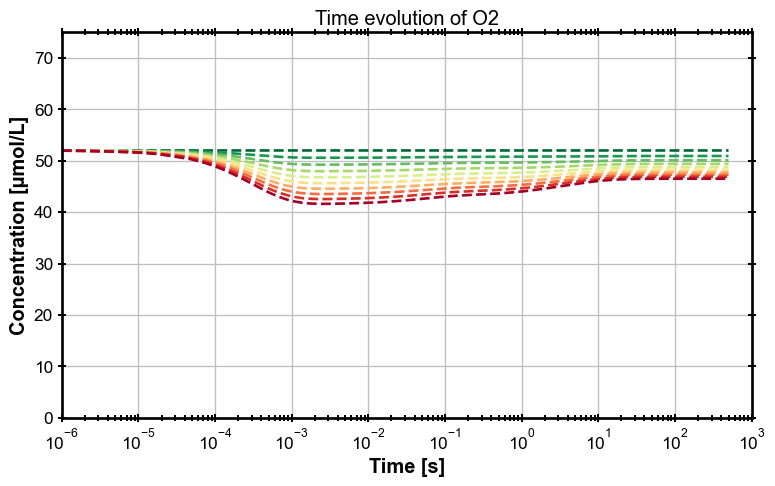

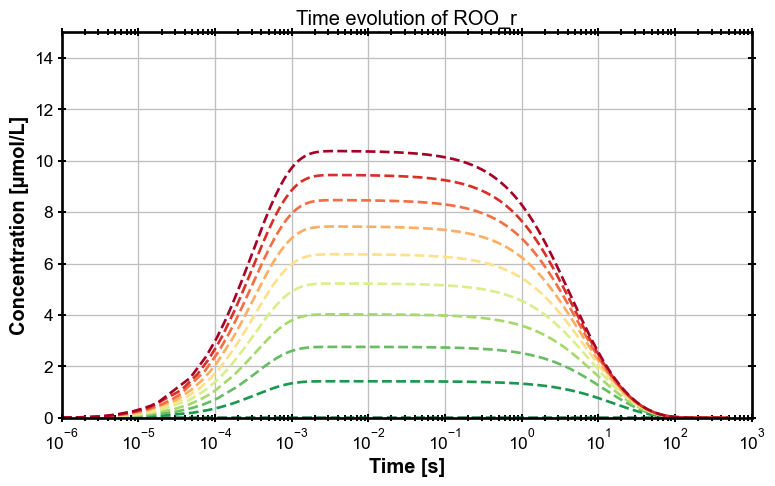

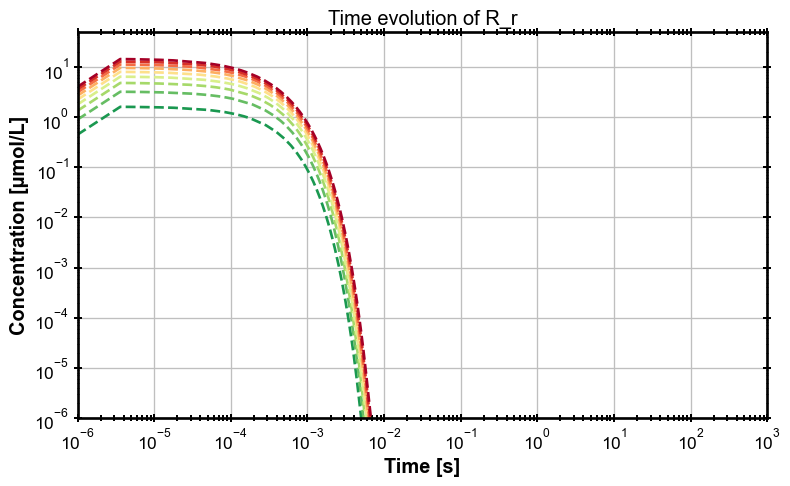

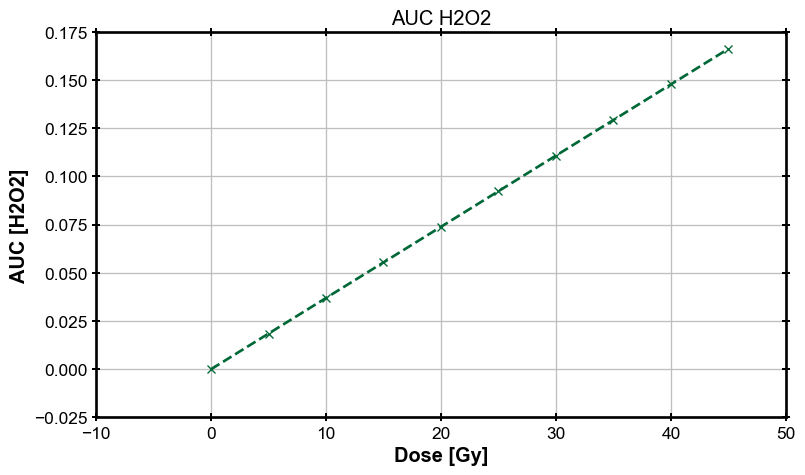

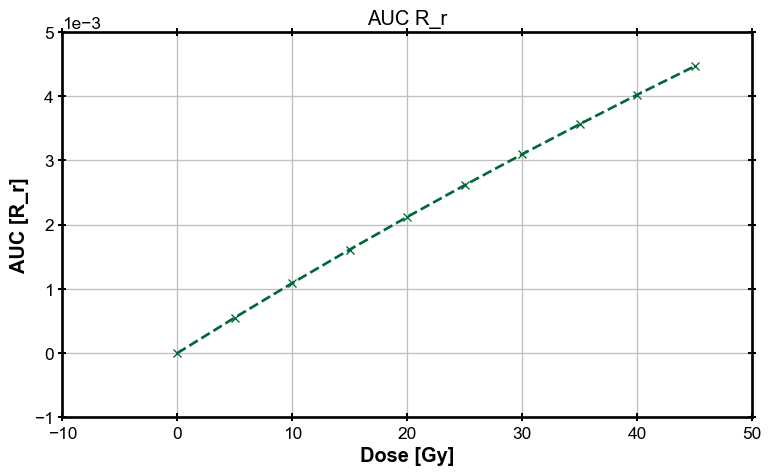

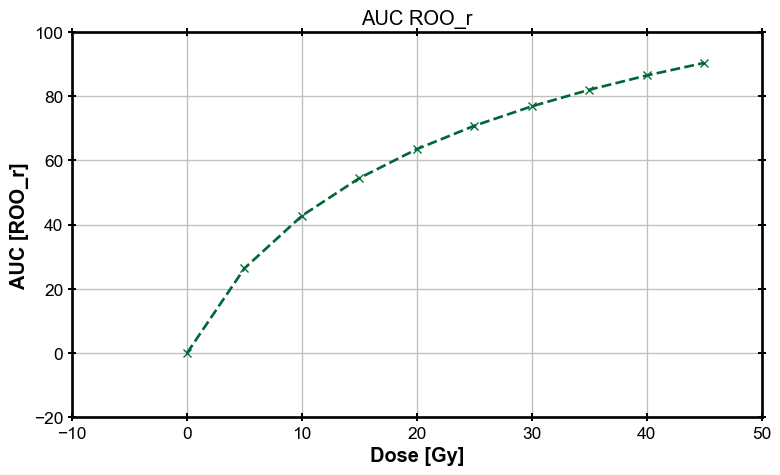

In [221]:

fig_man.set_brewer_map("RdYlGn", "diverging", 10, reverse=True)
sim_collection = flash
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802\FLASH")

G_species = ["OH_r", "e_aq", "H2O2", "H_r"]
for species in G_species:
    title = f"Time evolution of {species}"
    with fig_man.open(title) as (fig, ax):
        make_basic_plot(fig, ax, species, sim_collection, title, legend_title=sim_collection.label_name(), legend=False)
        fig.savefig(root / f"{fig_man.current}.png")
        
species = "O2"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title, yscale="linear", ylim=[0,75], legend_title=sim_collection.label_name(), legend=False)
    #RPlot.set_legend_right(ax)
    fig.savefig(root / f"{fig_man.current}.png")

species = "ROO_r"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title, yscale="linear", ylim=[0,15], legend_title=sim_collection.label_name(), legend=False)
    #RPlot.set_legend_right(ax)
    fig.savefig(root / f"{fig_man.current}.png")

species = "R_r"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title,ylim=[1e-6,50], legend=False)
    #RPlot.set_legend_right(ax)
    fig.savefig(root / f"{fig_man.current}.png")

species = "H2O2"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="linear", norm=False, legend=False)
    fig.savefig(root / f"{fig_man.current}.png")
    
species = "R_r"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="linear", norm=False, legend=False)
    fig.savefig(root / f"{fig_man.current}.png")

species = "ROO_r"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="linear", norm=False, legend=False)
    fig.savefig(root / f"{fig_man.current}.png")

In [12]:
uc.beam

ConstantBeam(dose_rate=0.25, timer=Timer(period=inf, on_time=inf, start_time=0.0), max_dose=2.5, label='default', time_at_max_dose=10.0, dose_per_pulse=inf, peak_dose_rate=0.25)

### Looking at reaction rates

In [7]:
from radiopyo.parser.reaction_parser import ReactionParser
import lark
parser = ReactionParser()


In [12]:
uc.env.reactions_involving("HO2_r")

[KReaction('H_r + O2 -> HO2_r', k_value=21000000000.0),
 KReaction('H_r + HO2_r -> H2O2', k_value=10000000000.0),
 KReaction('OH_r + HO2_minus -> OH_minus + HO2_r', k_value=7500000000.0)]

In [14]:
uc.env.reactions_involving("OH_r")

[KReaction('Fe_plus_plus + H2O2 -> Fe_plus_plus_plus + OH_minus + OH_r', k_value=1000.0),
 KReaction('OH_r + GSH -> RH_r', k_value=10000000000.0),
 KReaction('OH_r + RH -> R_r + H2O', k_value=1000000000.0),
 KReaction('e_aq + OH_r -> OH_minus', k_value=30000000000.0),
 KReaction('e_aq + H2O2 -> OH_minus + OH_r', k_value=11000000000.0),
 KReaction('e_aq + HO2_minus -> 2OH_minus + OH_r', k_value=3500000000.0),
 KReaction('H_r + H2O -> H2 + OH_r', k_value=10.0),
 KReaction('H_r + OH_r -> H2O', k_value=7000000000.0),
 KReaction('H_r + H2O2 -> OH_r + H2O', k_value=90000000.0),
 KReaction('2OH_r -> H2O2', k_value=5500000000.0),
 KReaction('OH_r + H2 -> H_r + H2O', k_value=42000000.0),
 KReaction('OH_r + OH_minus -> O_r_minus + H2O', k_value=13000000000.0),
 KReaction('OH_r + HO2_minus -> OH_minus + HO2_r', k_value=7500000000.0),
 KReaction('OH_r + O2_r_minus -> OH_minus + O2', k_value=8000000000.0),
 KReaction('O_r_minus + H2O -> OH_minus + OH_r', k_value=1800000.0),
 RadiolyticReaction('OH_

In [8]:
case = 10
rr_flash = flash[case].reconstruct_reactions()
#rr_conv = conv[case].reconstruct_reactions()

#rb_flash = flash[case].species_balance_evolution()
#rb_conv = conv[case].species_balance_evolution()

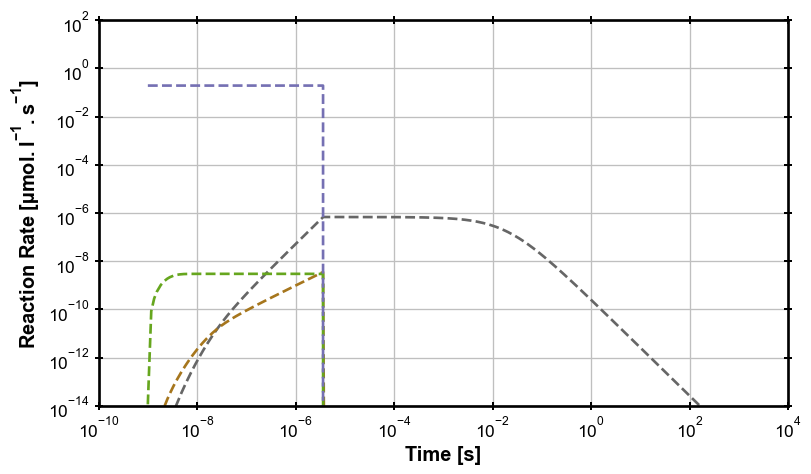

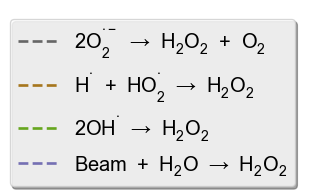

In [10]:
species = "H2O2"
fig_man.set_mpl_map("Dark2", 5, reverse=True)
with fig_man.open(f"Dynamic of {species}") as (fig, ax):
    for reaction in uc.env.reactions_involving_product(species):
        rlabel = reaction.as_label()
        try:
            label = reaction_dict_to_latex(parser.parse_reaction(reaction.__str__()))
        except lark.exceptions.UnexpectedCharacters:
            label = "$\mathregular{Beam\ +\ H_2O\ \\rightarrow\ H_2O_2}$"
        ax.plot(rr_flash.index, rr_flash[rlabel], label=label, marker="")
    
    for reaction in uc.env.reactions_involving_reactant(species):
        break
        rlabel = reaction.as_label()
        try:
            label = reaction_dict_to_latex(parser.parse_reaction(reaction.__str__()))
        except lark.exceptions.UnexpectedCharacters:
            label = reaction.__str__()
        ax.plot(rr_flash.index, rr_flash[rlabel], label=label, marker="", ls=":")
        
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [$\mathregular{µmol.l^{-1}.s^{-1}}$]")
    ax.set_ylim([1e-14,1e2])
    
fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels())#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
fig_l.set_size_inches(bbox.width*1.05, bbox.height*1.05)
fig_l.tight_layout(pad=-0.5)
#fig_l.savefig(root / f"LEGEND.png", transparent=True)



NameError: name 'rr_conv' is not defined

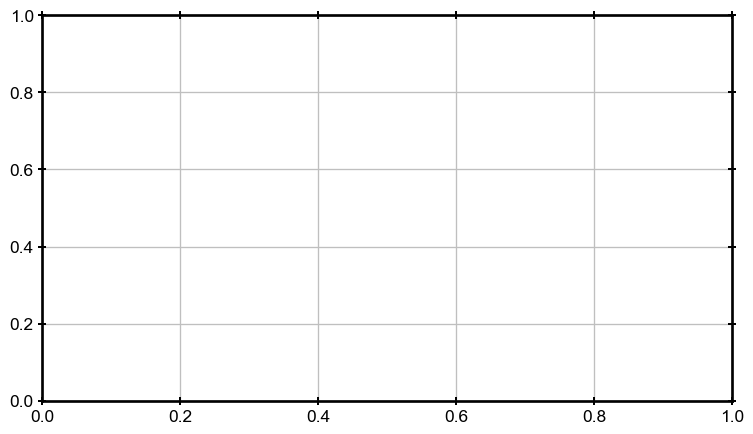

In [15]:
species = "H2O2"
fig_man.set_mpl_map("Dark2", 10, reverse=True)
with fig_man.open(f"CONV Dynamic of {species}") as (fig, ax):
    for reaction in uc.env.reactions_involving_product(species):
        rlabel = reaction.as_label()
        try:
            label = reaction_dict_to_latex(parser.parse_reaction(reaction.__str__()))
        except lark.exceptions.UnexpectedCharacters:
            label = "$\mathregular{Beam\ +\ H_2O\ \\rightarrow\ H_2O_2}$"
        ax.plot(rr_conv.index, rr_conv[rlabel], label=label, marker="")
    
    for reaction in uc.env.reactions_involving_reactant(species):
        break
        rlabel = reaction.as_label()
        try:
            label = reaction_dict_to_latex(parser.parse_reaction(reaction.__str__()))
        except lark.exceptions.UnexpectedCharacters:
            label = reaction.__str__()
        ax.plot(rr_conv.index, rr_conv[rlabel], label=label, marker="", ls=":")
        
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [$\mathregular{µmol.l^{-1}.s^{-1}}$]")
    ax.set_ylim([1e-14,1e2])
    
fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels())#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
fig_l.set_size_inches(bbox.width*1.05, bbox.height*1.05)
fig_l.tight_layout(pad=-0.5)
#fig_l.savefig(root / f"LEGEND.png", transparent=True)

In [33]:
rb_flash["H2O2"].min()

-5.520660352715409e-05

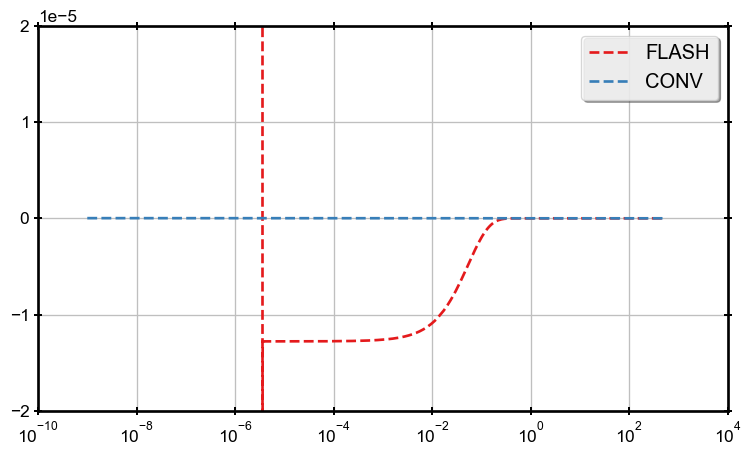

In [36]:
fig_man.set_mpl_map("Set1", 9, reverse=False)
with fig_man.open("H2O2 time balance") as (fig, ax):
    ax.plot(rb_flash.index, rb_flash["H2O2"], label="FLASH", marker="")
    ax.plot(rb_conv.index, rb_conv["H2O2"], label="CONV", marker="")
    ax.legend()
    ax.set_xscale("log")
    ax.set_ylim([-2e-5, 2e-5])

from radiopyo.parser.reaction_parser import ReactionParser
parser = ReactionParser()
pr = parser.parse_reaction(str(x))

In [8]:
pr

{'reactants': {'O2_r_minus': (O2_r_minus, 2)},
 'products': {'H2O2': (H2O2, 1), 'O2': (O2, 1)},
 'constants': {},
 'enzyme': None}

In [9]:
pr["reactants"]["O2_r_minus"][0].to_latex()

'$O_2^{.-}$'

In [10]:
pr["products"]["H2O2"][0].to_latex().strip("$")

'H_2O_2'

In [18]:
reaction_dict_to_latex(pr)

'$\\mathregular{2O_2^{.-}\\ ->\\ H_2O_2\\ +\\ O_2}$'

## CONV simulations

In [23]:
conv = rp.simulation.utils.ResCollection("Dose [Gy]")
rp.set_logging_level("ERROR")
for dose in flash.keys():
    print(f"Simulations at : {dose} Gy")
    uc.set_beam("conv-constant")
    uc.beam.update_beam_param(max_dose=dose)
    print(uc.beam)
    sim = uc.prepare_chunked_run([1e-9, 500],
                                 atol=0.2,
                                 rtol=1e-8,
                                 use_jac=False,
                                 max_step_size_on=uc.beam.time_at_max_dose/1e3,
                                 max_step_size_off=0.1,
                                 max_step_size_final=0.1,
                                )
    conv.push(dose, sim.run())
    

Simulations at : 0.0 Gy
ConstantBeam(dose_rate=0.25, max_dose=0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

Simulations at : 5 Gy
ConstantBeam(dose_rate=0.25, max_dose=5)


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 10 Gy
ConstantBeam(dose_rate=0.25, max_dose=10)


  0%|          | 0/2 [00:00<?, ?it/s]

In [171]:
fig_man.current

'AUC_ROO_r'

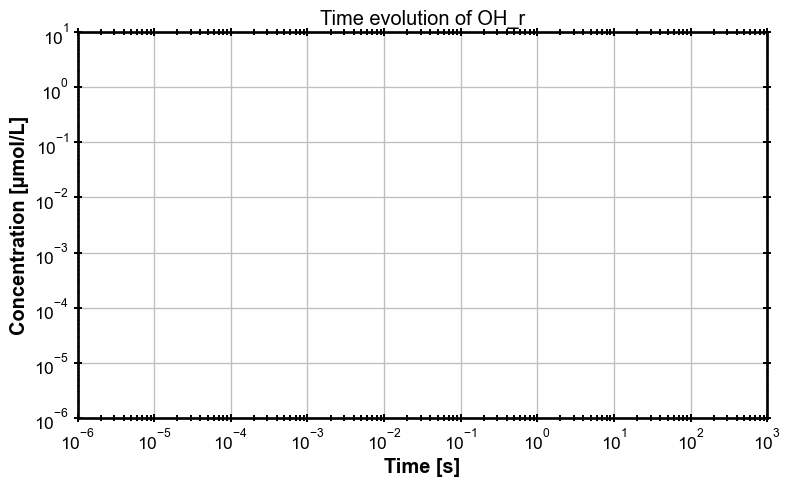

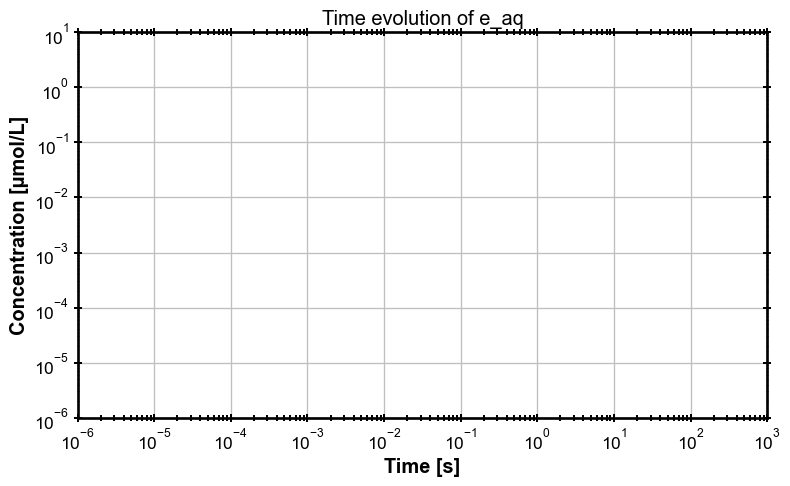

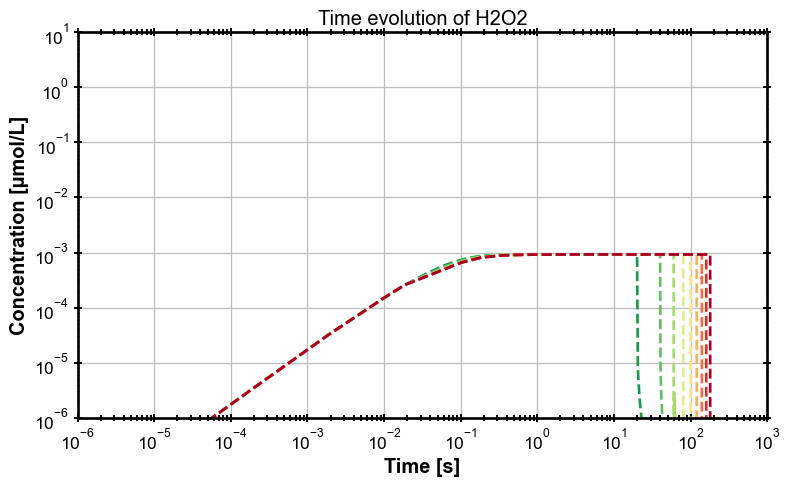

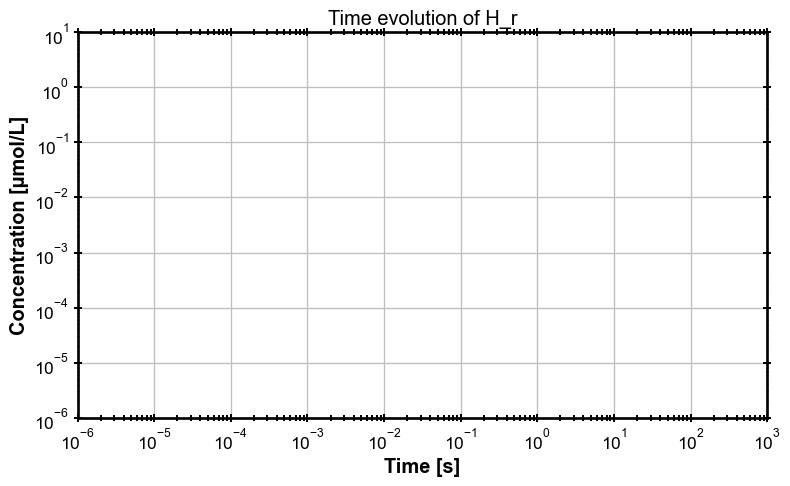

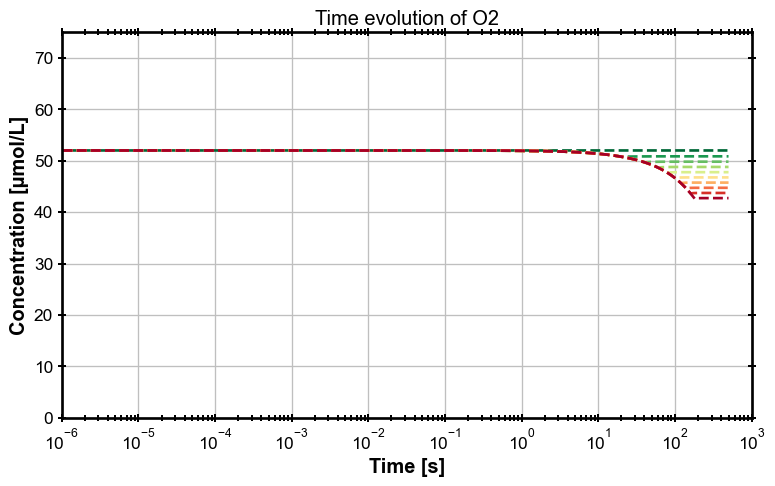

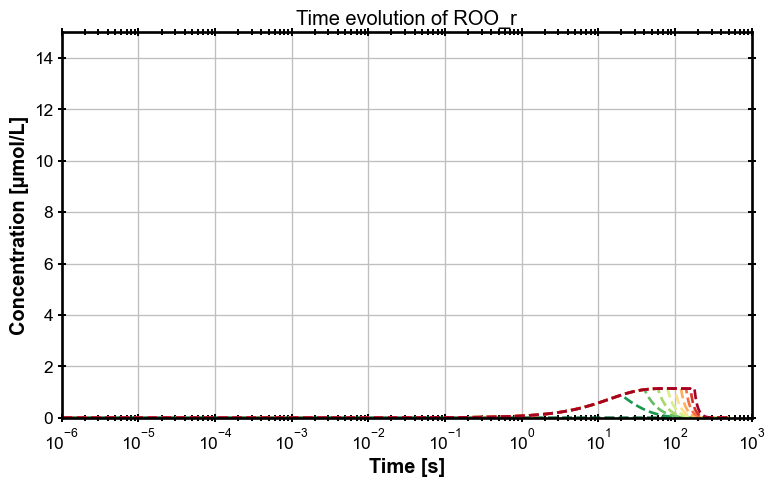

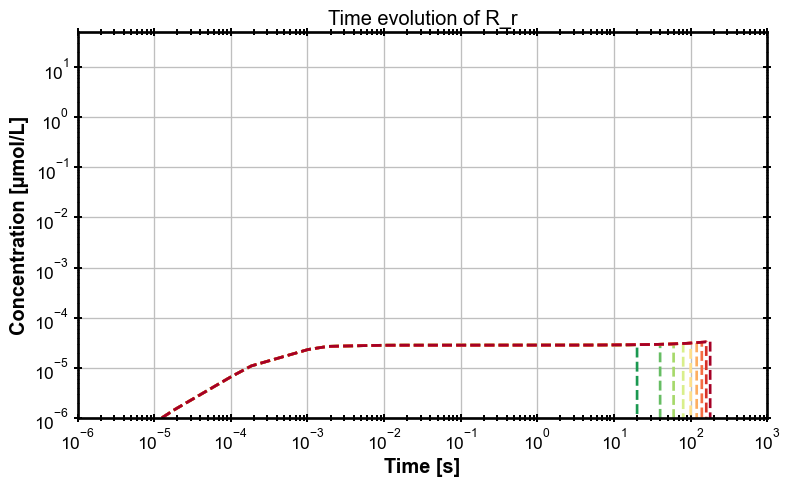

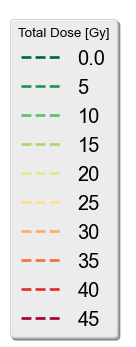

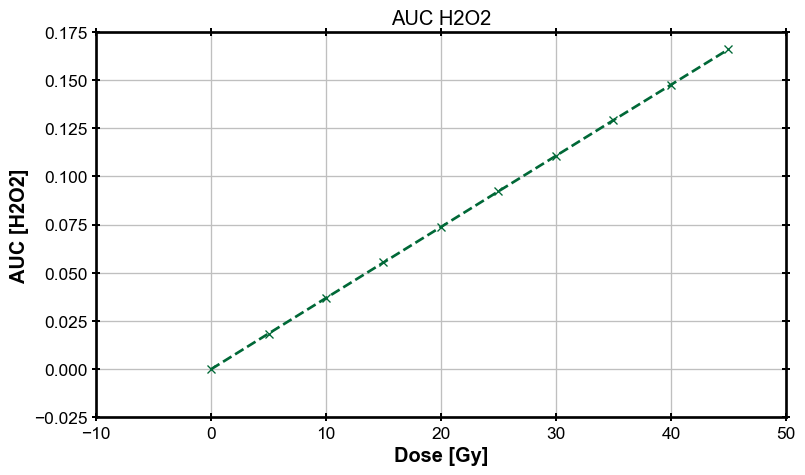

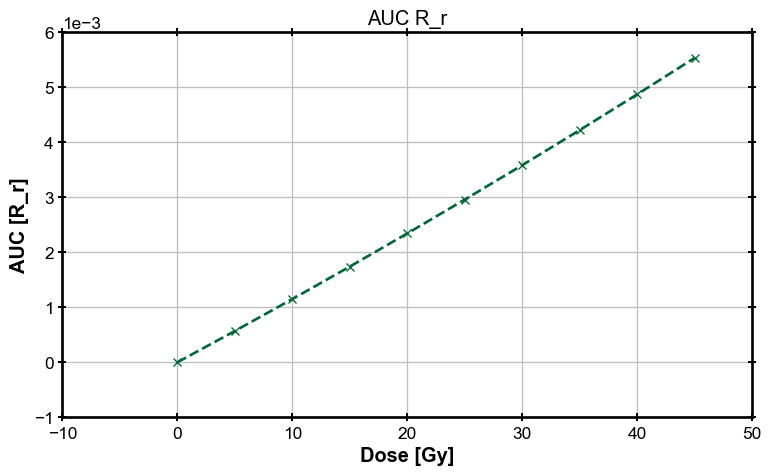

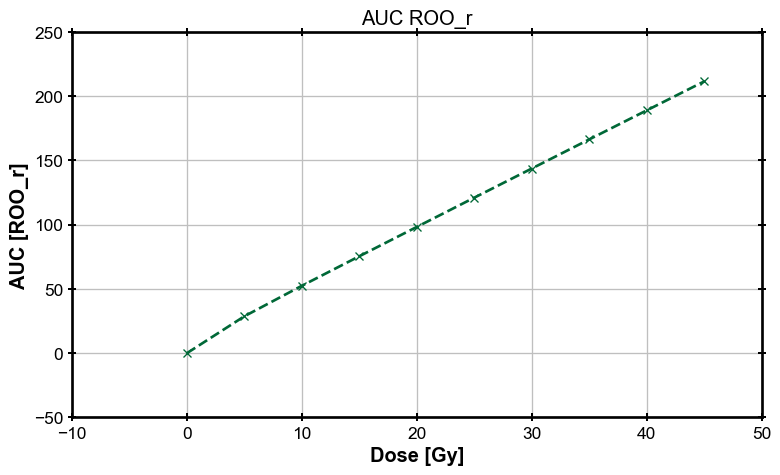

In [210]:

fig_man.set_brewer_map("RdYlGn", "diverging", 10, reverse=True)
sim_collection = conv
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802\CONV")
G_species = ["OH_r", "e_aq", "H2O2", "H_r"]
for species in G_species:
    title = f"Time evolution of {species}"
    with fig_man.open(title) as (fig, ax):
        make_basic_plot(fig, ax, species, sim_collection, title, legend=False)
        fig.savefig(root / f"{fig_man.current}.png")

species = "O2"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title, yscale="linear", ylim=[0,75], legend=False)
    #RPlot.set_legend_right(ax)
    fig.savefig(root / f"{fig_man.current}.png")

species = "ROO_r"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title, yscale="linear", ylim=[0,15], legend=False)
    #RPlot.set_legend_right(ax)
    fig.savefig(root / f"{fig_man.current}.png")

species = "R_r"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title, legend=False, ylim=[1e-6,50])
    #RPlot.set_legend_right(ax)
    fig.savefig(root / f"{fig_man.current}.png")

fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels(), title="Total Dose [Gy]")#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
fig_l.set_size_inches(bbox.width*1.05, bbox.height*1.05)
fig_l.tight_layout(pad=-0.5)
fig_l.savefig(root / f"LEGEND.png", transparent=True)

species = "H2O2"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="linear", norm=False, legend=False)
    fig.savefig(root / f"{fig_man.current}.png")
    
species = "R_r"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="linear", norm=False, legend=False)
    fig.savefig(root / f"{fig_man.current}.png")

species = "ROO_r"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="linear", norm=False, legend=False)
    fig.savefig(root / f"{fig_man.current}.png")
    


## Compare CONV and FLASH

In [161]:
species = ["H2O2", "ROO_r", "R_r", "O2", "e_aq", "OH_r"]
index = pd.MultiIndex.from_product([species, ["flash", "conv"]])

df_cmp = pd.DataFrame(index=flash.keys(), columns=index)

for elt in species:
    df_cmp.loc[:,(elt,"flash")] = extract_AUC(elt, flash)
    df_cmp.loc[:,(elt,"conv")] = extract_AUC(elt, conv)

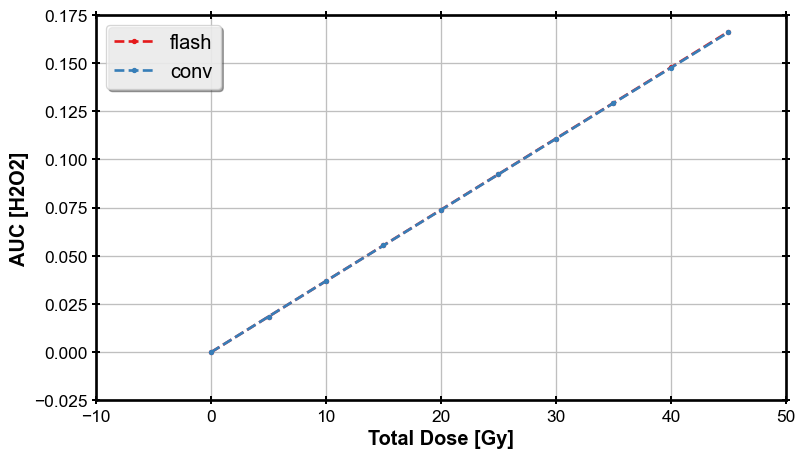

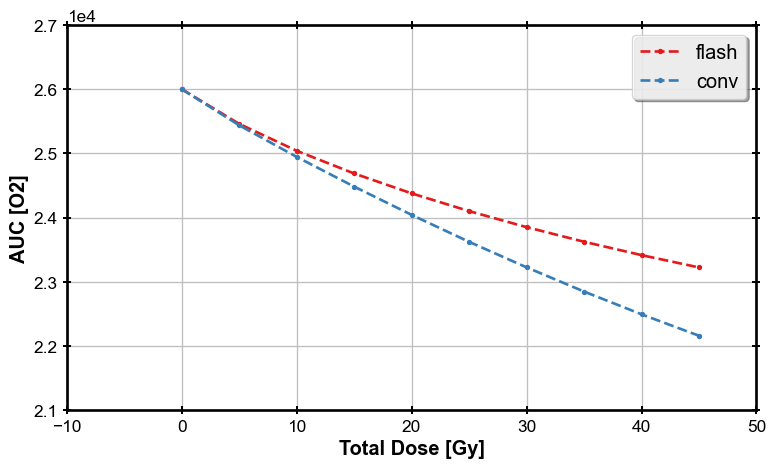

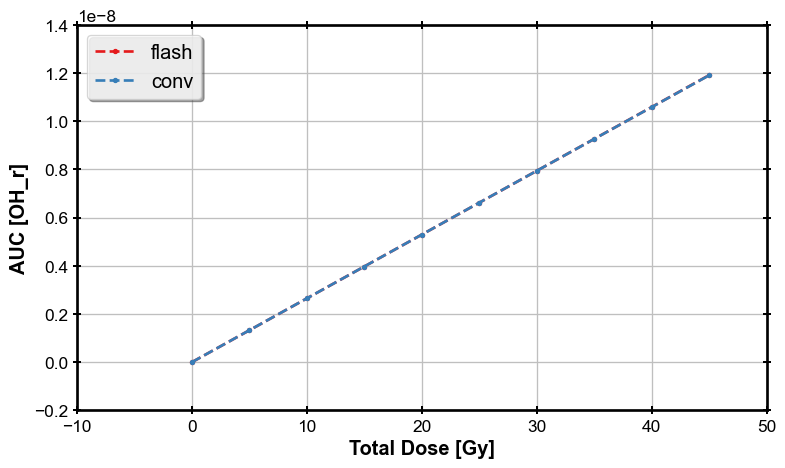

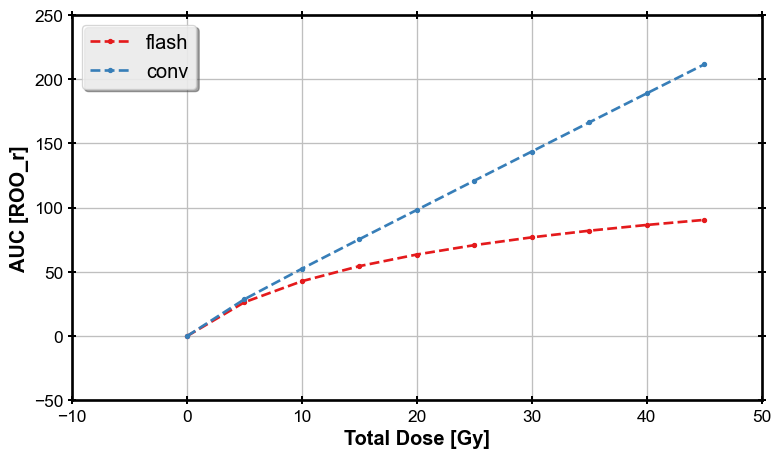

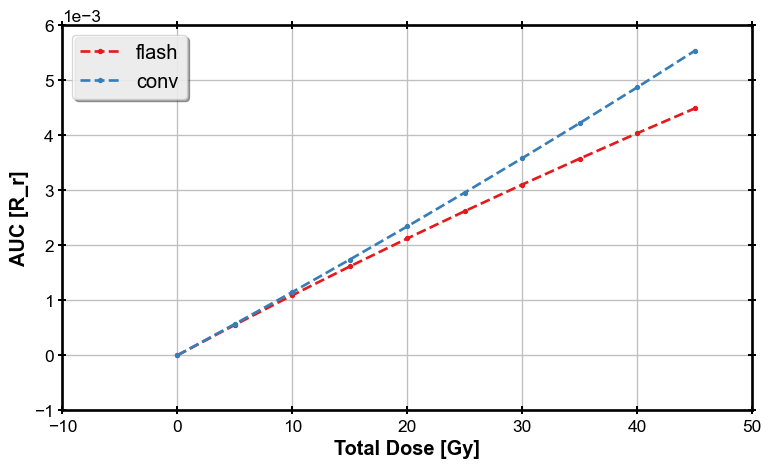

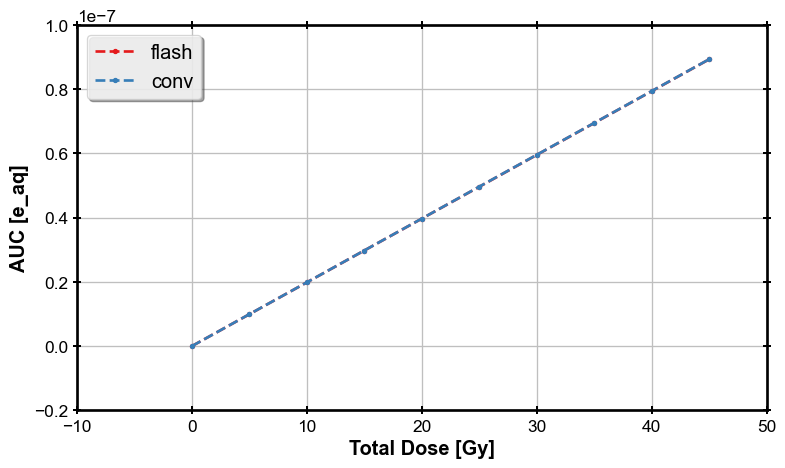

In [223]:
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\MEETINGS\20230802")

fig_man.set_mpl_map("Set1", 9, reverse=False)
for grp, df in df_cmp.groupby(level=0, axis=1):
    title = f"AUC comparisons for {grp}"
    with fig_man.open(title) as (fig, ax):
        for sp, col in df:
            ax.plot(df.index, df[(sp,col)], label=col, marker="o", markersize=3)
        ax.legend()
        ax.set_yscale("linear")
        ax.set_xlabel("Total Dose [Gy]")
        ax.set_ylabel(f"AUC [{grp}]")
        fig.savefig(root/f"{fig_man.current}.png")

# Dose Rate study

In [164]:
file = Path(rf"configuration_Oxford.toml")
rp.set_logging_level("INFO")
uc = rp.UnitCell.from_toml(file)

2023-08-02 11:55:49,309::radiopyo::INFO::Loading config from file: configuration_Oxford.toml
2023-08-02 11:55:49,313::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\config_Labarbe.toml
2023-08-02 11:55:49,315::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-08-02 11:55:49,514::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\reactions_biology.toml
2023-08-02 11:55:49,555::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-08-02 11:55:49,823::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-08-02 11:55:50,065::radiopyo::INFO::File is loaded
2023-08-02 11:55:50,066::radiopyo::INFO::Beam configuration detected in config file
2023-08-02 11:55:50,066::radiopyo::INFO::BEAM:: Found beam 'conv' as pulsed -> {'dose_rate': 0.25, 'period': 0.04, 'on_time': 3.333333333333

## FLASH simulations

In [105]:
uc.beam.time_at_max_dose

SinglePulseBeam(dose_rate=1.0, timer=Timer(period=inf, on_time=inf, start_time=0.0), max_dose=10, label='default', time_at_max_dose=10.0, dose_per_pulse=inf, peak_dose_rate=1.0)

In [120]:
np.geomspace(5e6,1,10)

array([5.00000000e+06, 9.00824115e+05, 1.62296817e+05, 2.92401774e+04,
       5.26805138e+03, 9.49117546e+02, 1.70997595e+02, 3.08077514e+01,
       5.55047308e+00, 1.00000000e+00])

In [135]:
uc.set_beam("flash")
uc.beam.update_beam_param(max_dose=10, dose_rate=1)
print(uc.beam)
print(uc.beam.time_at_max_dose)
uc.run([1e-9, 500],
       atol=0.70,
       rtol=1e-4,
       use_jac=False,
       )

SinglePulseBeam(dose_rate=1, max_dose=10, start_time=0.0)
10.0


In [169]:
flash_dr = rp.simulation.utils.ResCollection("Dose Rate [Gy/s]")
rp.set_logging_level("ERROR")
for dr in [1, 1e1, 1e2, 1e3, 5e3, 1e4, 1e5, 1e6]:
    print(f"Simulations at : {dr} Gy/s")    
    uc.set_beam("flash")
    uc.beam.update_beam_param(max_dose=10, dose_rate=dr)
    sim = uc.prepare_chunked_run([1e-9, 500],
                                 atol=0.7,
                                 rtol=1e-4,
                                 use_jac=False,
                                 max_step_size_on=uc.beam.time_at_max_dose/1e3,
                                 max_step_size_off=0.1,
                                 max_step_size_final=0.1,
                                )
    flash_dr.push(round(dr,1), sim.run())
    

Simulations at : 1 Gy/s


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 10.0 Gy/s


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 100.0 Gy/s


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 1000.0 Gy/s


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 5000.0 Gy/s


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 10000.0 Gy/s


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 100000.0 Gy/s


  0%|          | 0/2 [00:00<?, ?it/s]

Simulations at : 1000000.0 Gy/s


  0%|          | 0/2 [00:00<?, ?it/s]

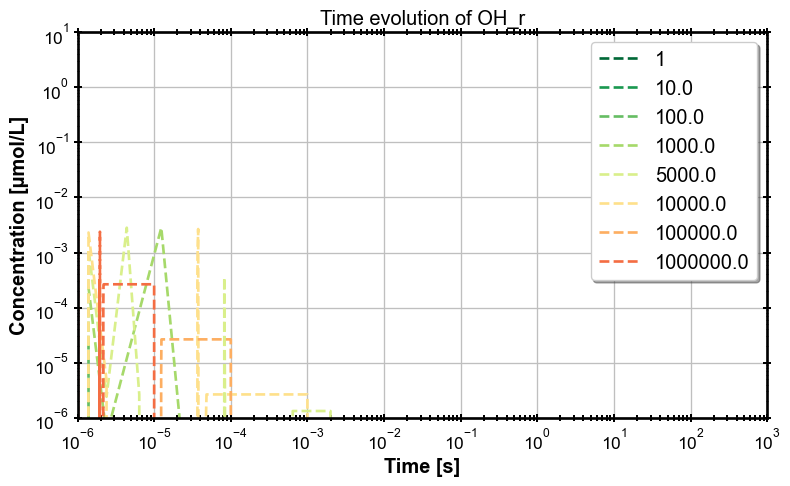

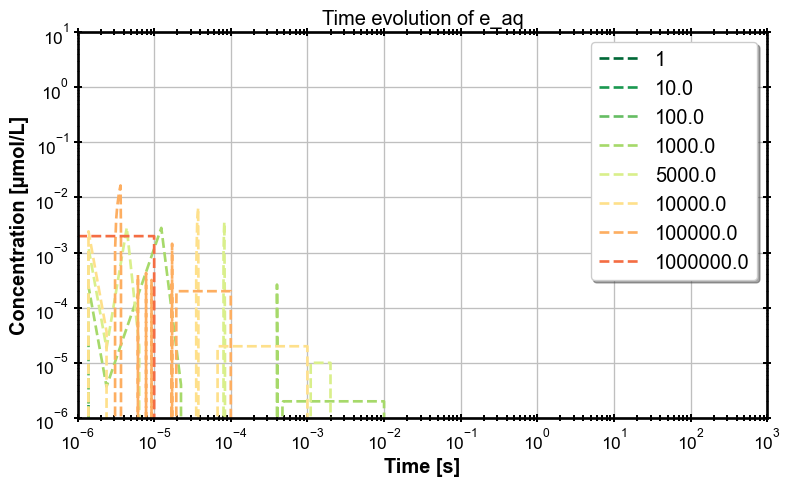

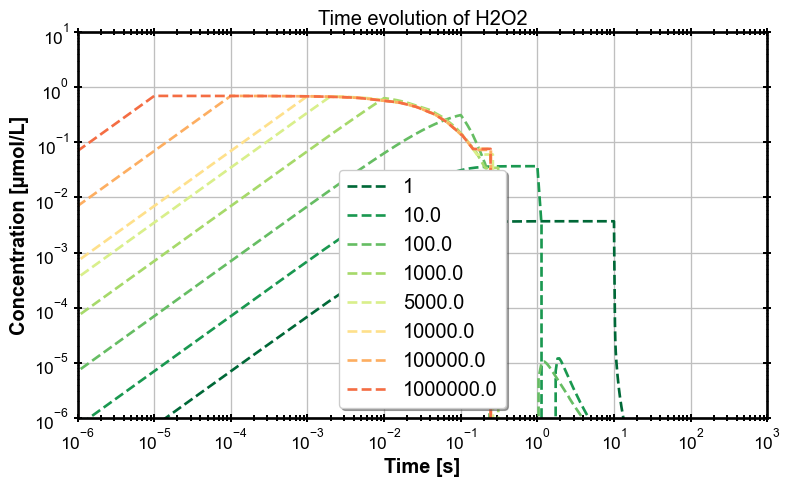

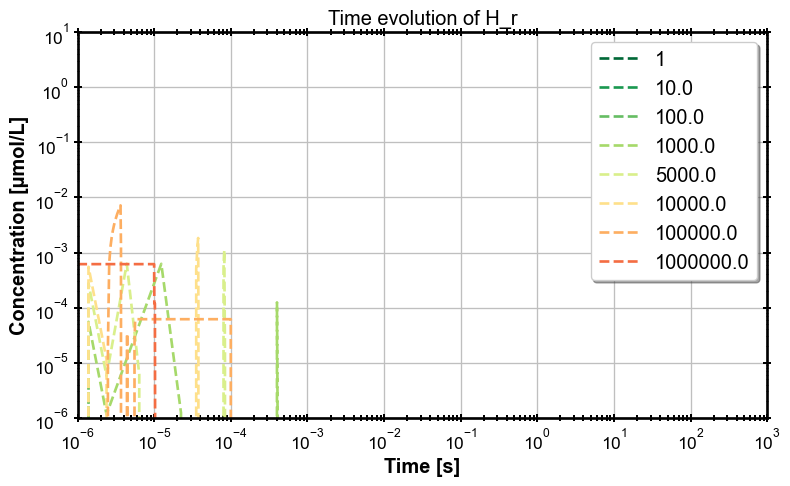

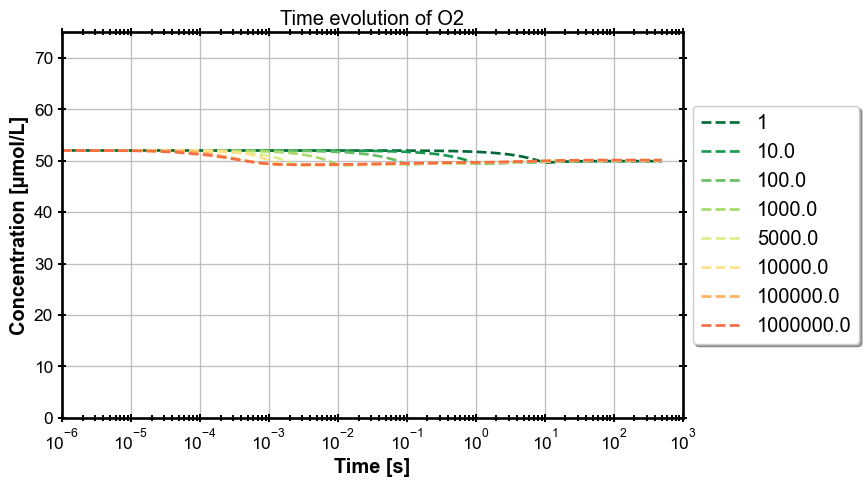

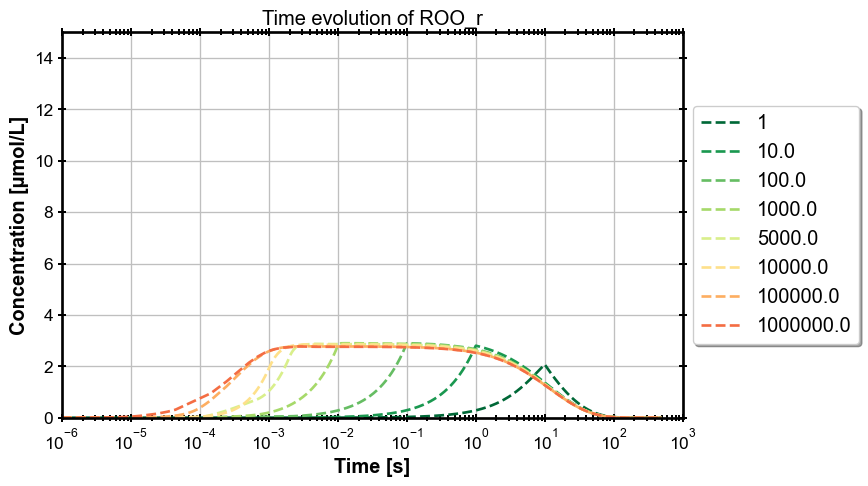

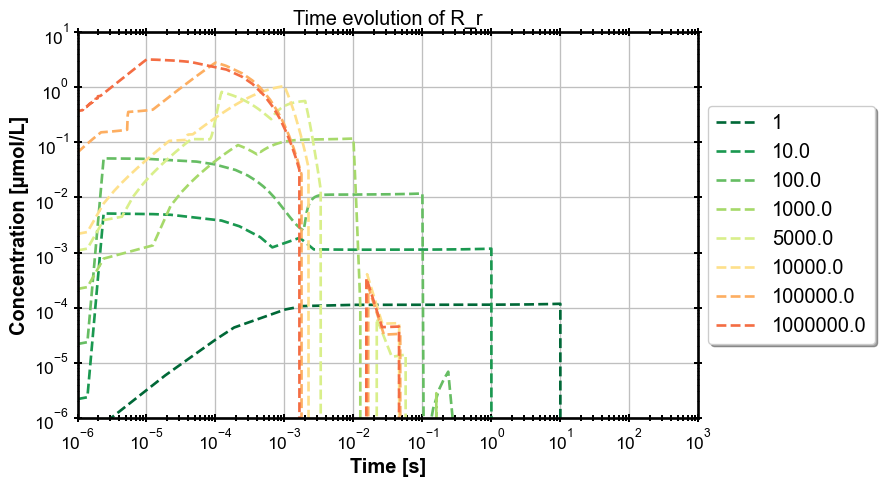

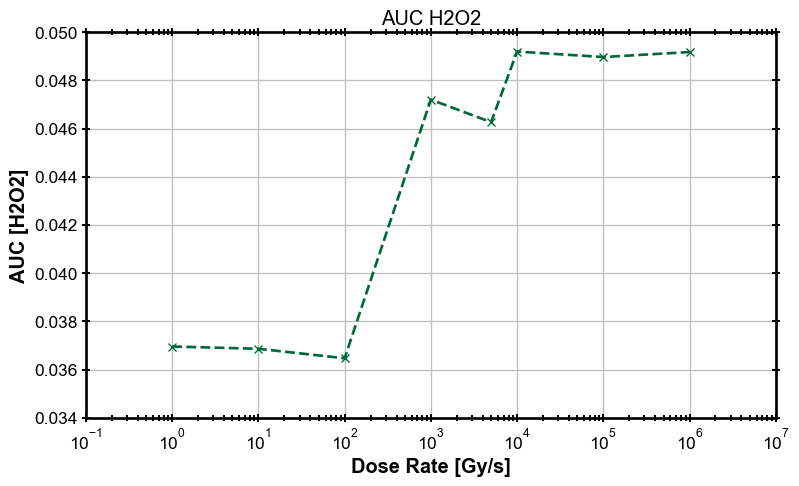

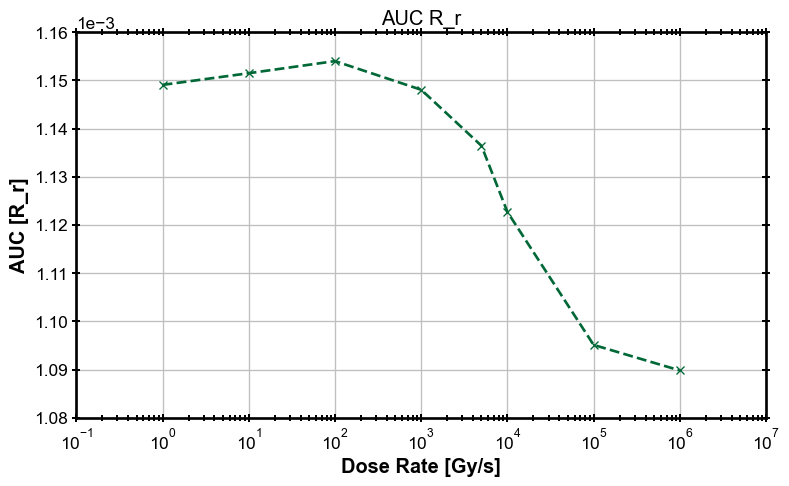

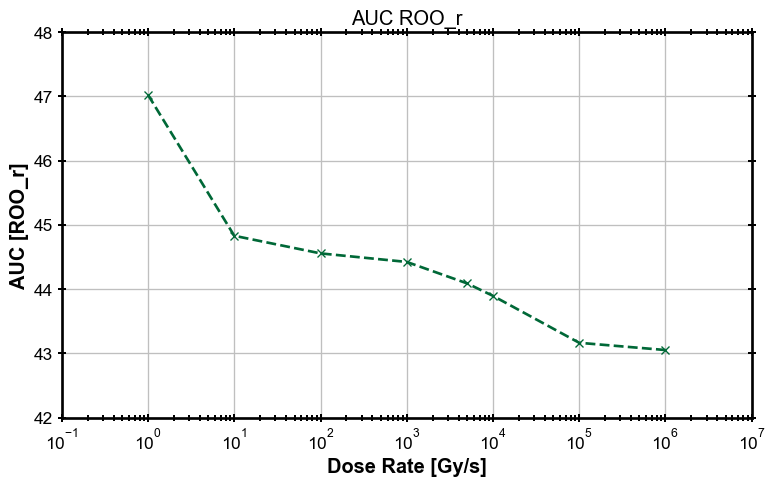

In [170]:

fig_man.set_brewer_map("RdYlGn", "diverging", 10, reverse=True)
sim_collection = flash_dr

G_species = ["OH_r", "e_aq", "H2O2", "H_r"]
for species in G_species:
    title = f"Time evolution of {species}"
    with fig_man.open(title) as (fig, ax):
        make_basic_plot(fig, ax, species, sim_collection, title)

species = "O2"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title, yscale="linear", ylim=[0,75])
    RPlot.set_legend_right(ax)

species = "ROO_r"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title, yscale="linear", ylim=[0,15])
    RPlot.set_legend_right(ax)

species = "R_r"
title = f"Time evolution of {species}"
with fig_man.open(title) as (fig, ax):
    make_basic_plot(fig, ax, species, sim_collection, title)
    RPlot.set_legend_right(ax)

species = "H2O2"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="log", norm=False,)
    
species = "R_r"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="log", norm=False)

species = "ROO_r"
title = f"AUC {species}"
with fig_man.open(title) as (fig, ax):
    plot_AUC(fig, ax, species, sim_collection, title, xscale="log", norm=False)